In [2]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score

In [20]:
class GMM:
    def __init__(self):
        self.num_clusters = 2
        self.num_pc = 5
        self.iterations = 0
        
    def fit(self, data, num_clusters, pc_components):
        self.data = data
        self.num_clusters = num_clusters
        self.num_pc = pc_components
        self.preprocess()
        self.initialize_params()
        self.runEM()
        
    def get_data(self):
        return self.data
    
    def runEM(self):
        while(self.curr_log - self.prev_log >= 0.000000001):
            self.run_iter()
        self.likelihood = self.curr_log
        
    def preprocess(self):
        self.data = (self.data - np.mean(self.data,axis=0)) / np.std(self.data,axis=0)
        cov_data = np.cov(self.data, rowvar=False)
        
        # ChatGPT Prompt: How to find eigen vectors and eigen values from covariance matrix to perform PCA.
        eigenvalues, eigenvectors = np.linalg.eig(cov_data)

        # ChatGPT Prompt: How to sort both eigenvalues and eigenvectors by using argsort on eigenvalues.
        sorted_indices = np.argsort(eigenvalues)[::-1] 
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        
        self.eigenvectors = eigenvectors
        self.data = np.real(np.dot(self.data, eigenvectors[:, :self.num_pc]))
    
    def initialize_params(self):
        self.iterations = 0
        self.means = self.data[:self.num_clusters, :] 
        self.cov_mat = [np.eye(len(self.data[0])) for _ in range(self.num_clusters)]
        self.weights = np.full(self.num_clusters, 1 / self.num_clusters)
        self.curr_log = -10000000
        self.prev_log = self.curr_log - 5
        
    def run_iter(self):
        responsibilities = np.zeros((len(self.data), self.num_clusters))
        for k in range(self.num_clusters):
            responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(self.data, mean=self.means[k], cov=self.cov_mat[k])
        
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        
        diagonal_matrix = np.diag([1e-6] * self.num_pc) 
        for k in range(self.num_clusters):
            N = np.sum(responsibilities[:, k])

            self.means[k] = (responsibilities[:, k].reshape(-1, 1) * self.data).sum(axis=0) / N
            self.cov_mat[k] = np.dot((responsibilities[:, k][:, np.newaxis] * (self.data - self.means[k])).T, self.data - self.means[k])/N

            self.cov_mat[k] = np.diag(np.diag(self.cov_mat[k]))
            self.cov_mat[k] = self.cov_mat[k] + diagonal_matrix
            self.weights[k] = N / len(self.data) 

        log_likelihoods = np.zeros(self.data.shape[0])
        self.responsibilities = responsibilities
        for c in range(self.num_clusters):
            log_likelihoods += self.weights[c] * multivariate_normal.pdf(self.data, mean=self.means[c], cov=self.cov_mat[c])
        
        log_likelihood = np.sum(np.log(log_likelihoods))
        
        self.prev_log = self.curr_log
        self.curr_log = log_likelihood
        self.iterations = self.iterations + 1
        
    def get_params(self):
        return [self.iterations, self.likelihood, self.cov_mat, self.means, self.weights]
    
    def predict_membership(self):
        return np.argmax(self.responsibilities, axis=1)

In [4]:
df = pd.read_csv("./SMAI-Dataset-customer-dataset/data.csv")
print(df)

      Index  Gender  Marital status  Age  Education  Income  Occupation  \
0         0       0               0   67          2  124670           1   
1         1       1               1   22          1  150773           1   
2         2       0               0   49          1   89210           0   
3         3       0               0   45          1  171565           1   
4         4       0               0   53          1  149031           1   
...     ...     ...             ...  ...        ...     ...         ...   
1995   1995       1               0   47          1  123525           0   
1996   1996       1               1   27          1  117744           1   
1997   1997       0               0   31          0   86400           0   
1998   1998       1               1   24          1   97968           0   
1999   1999       0               0   25          0   68416           0   

      Settlement size  
0                   2  
1                   2  
2                   0  
3  

In [24]:
df = pd.read_csv("./SMAI-Dataset-customer-dataset/data.csv")
df.drop('Index', axis = 1,inplace = True)
data = df.to_numpy()
gmm = GMM()
gmm.fit(data, 100, 7)
params = gmm.get_params()
print("My Model Log-Likelihood:")
print(params[1])

print("-----------------------------------------------")

print("My Model Weights:")
print(params[4])

print("-----------------------------------------------")

print("Sklearn Model Weights:")

sklearn_gmm = GaussianMixture(n_components=100, covariance_type='diag')
sklearn_gmm.fit(gmm.get_data())
sklearn_weights = sklearn_gmm.weights_
print(sklearn_weights)

My Model Log-Likelihood:
-899.633061732667
-----------------------------------------------
My Model Weights:
[0.01706183 0.01197635 0.01096909 0.01058599 0.00496224 0.00954683
 0.00600669 0.01047562 0.01711899 0.00801664 0.02802584 0.02434654
 0.01002969 0.006      0.0335348  0.01727669 0.00494863 0.00849891
 0.00500121 0.01171278 0.00399565 0.01005974 0.00653224 0.01454992
 0.01216259 0.01259854 0.0195     0.02725662 0.00650001 0.00499914
 0.00886921 0.00499767 0.00715549 0.0084999  0.0015     0.00549878
 0.0015     0.0025     0.01101026 0.00928722 0.0025     0.00643294
 0.00401097 0.00798837 0.00934763 0.001      0.02099999 0.023906
 0.01185463 0.01306031 0.01100121 0.00399995 0.00799359 0.005
 0.0015     0.0265     0.00455219 0.00932835 0.00496904 0.0141027
 0.01682074 0.00850857 0.00149999 0.00550674 0.0193386  0.00494177
 0.01344649 0.0125657  0.01341726 0.0039918  0.00801155 0.02848746
 0.00736603 0.0179849  0.00900876 0.00543902 0.002      0.0050103
 0.00907747 0.01351302 0.0104

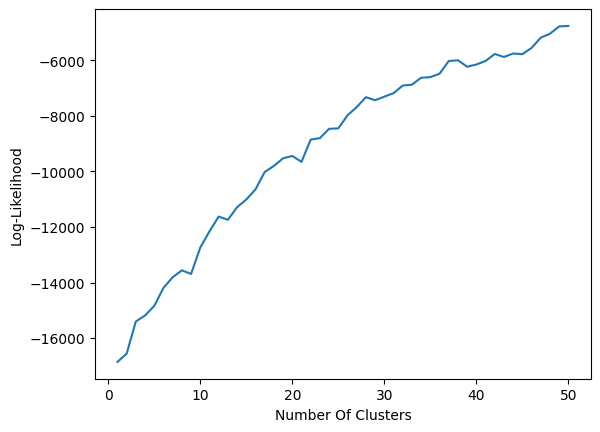

In [25]:
num_cl = []
log_likelihoods = []

for i in range(1,51):
    gmm = GMM()
    gmm.fit(data, i, 7)
    params = gmm.get_params()
    log_likelihoods.append(params[1])
    num_cl.append(i)
    
plt.plot(num_cl, log_likelihoods)
plt.xlabel("Number Of Clusters")
plt.ylabel("Log-Likelihood")
plt.show()

In [15]:
wine_data = load_wine()
X = np.asarray(wine_data.data)
y = np.asarray(wine_data.target)

aic = []
bic = []
num_cl = []
num_features = 2

for k in range(1,51):
    num_cl.append(k)
    wine_gmm = GMM()
    wine_gmm.fit(X, k, num_features)
    params = wine_gmm.get_params()
    log_likelihood = params[1]
    bic_val = -2 * log_likelihood + (k * num_features + (k * num_features*(num_features+1)/2) + k-1) * np.log(len(X))
    aic_val = -2 * log_likelihood + 2* (k * num_features + (k * num_features*(num_features+1)/2) + k-1)
    bic.append(bic_val)
    aic.append(aic_val)

optimal_k_bic = 1 + np.argmin(bic)
optimal_k_aic = 1 + np.argmin(aic)

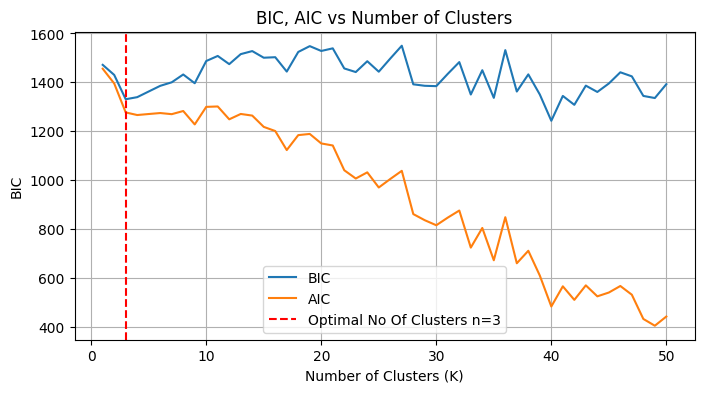

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(num_cl, bic, linestyle='-', label='BIC')
plt.plot(num_cl, aic, linestyle='-', label='AIC')
plt.axvline(x=3, color='red', linestyle='--', label='Optimal No Of Clusters n=3')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('BIC')
plt.title('BIC, AIC vs Number of Clusters')
plt.grid(True)
plt.legend()
plt.show()

The Cluster Means are:

[[-0.07601834  1.73606061]
 [ 2.28888211 -0.95994724]
 [-2.74392982 -1.2141906 ]]


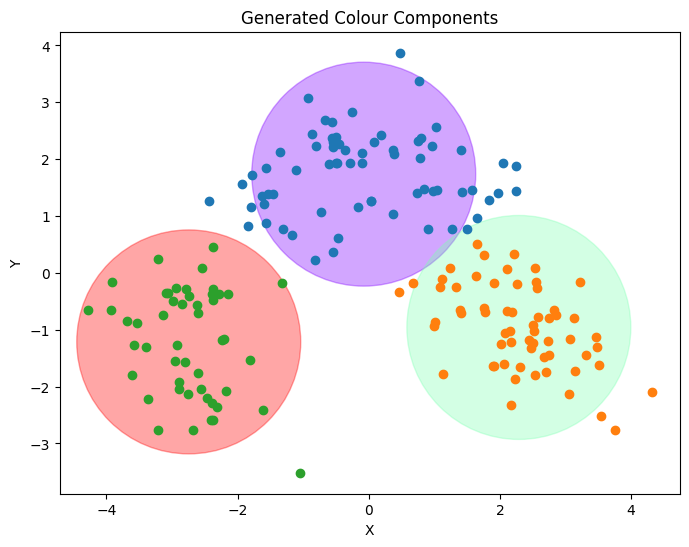

In [17]:
# ChatGPT Prompt: Write code to plot the means and their respective data using matplotlib given all the data

num_clusters = 3

X = (X-np.mean(X,axis=0))/np.std(X,axis=0)

kmeans = KMeans(n_clusters=num_clusters, n_init=10)
pca_X = PCA(n_components=2) 
red_X = pca_X.fit_transform(X)

kmeans.fit(red_X)
centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

x_data = red_X[:, 0]  
y_data = red_X[:, 1]  

x_cluster = centers[:, 0]
y_cluster = centers[:, 1]

print("The Cluster Means are:")
print()
print(centers)

colors = plt.cm.rainbow(np.linspace(0, 1, num_clusters))

alpha = 0.35
colors[:, 3] = alpha

custom_cmap = ListedColormap(colors)

plt.figure(figsize=(8, 6))
plt.scatter(x_cluster, y_cluster, c=np.arange(len(x_cluster)), cmap=custom_cmap, s=26000, label = 'Predicted Color Components')

for i in range(num_clusters):
    plt.scatter(red_X[cluster_labels == i, 0], red_X[cluster_labels == i, 1], label=f'Cluster {i}', cmap=custom_cmap)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Colour Components')
plt.show()

For n_clusters = 2, the silhouette score is 0.4649140908920151
For n_clusters = 3, the silhouette score is 0.5610505693103247
For n_clusters = 4, the silhouette score is 0.49142133957103173
For n_clusters = 5, the silhouette score is 0.446496932009863
For n_clusters = 6, the silhouette score is 0.43170575944675704
For n_clusters = 7, the silhouette score is 0.4219428974727115
For n_clusters = 8, the silhouette score is 0.40808048784150297
For n_clusters = 9, the silhouette score is 0.38452803767595833
For n_clusters = 10, the silhouette score is 0.40700623079563536


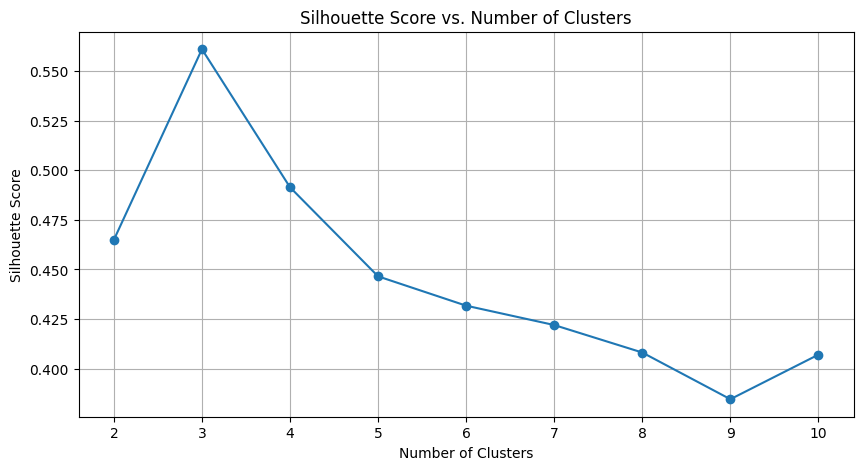

The optimal number of clusters with K-Means is 3


In [22]:
# ChatGPT Prompt: Write code to calculate silhouette score for K means clustering and then find optimal number of clusters
# Entire block has been generated by ChatGPT

min_clusters = 2
max_clusters = 10
silhouette_scores = []

for n_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(red_X)
    silhouette_avg = silhouette_score(red_X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg}")

# Find the optimal number of clusters
optimal_clusters = np.argmax(silhouette_scores) + min_clusters

plt.figure(figsize=(10, 5))
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.xticks(range(min_clusters, max_clusters + 1))
plt.grid(True)
plt.show()

print(f"The optimal number of clusters with K-Means is {optimal_clusters}")

For n_clusters = 2, the silhouette score is 0.20798888204285215
For n_clusters = 3, the silhouette score is 0.2506668463917112
For n_clusters = 4, the silhouette score is 0.1793798351251621
For n_clusters = 5, the silhouette score is 0.145801921062107
For n_clusters = 6, the silhouette score is 0.13337465072646248
For n_clusters = 7, the silhouette score is 0.12332275933036858
For n_clusters = 8, the silhouette score is 0.1222286154087235
For n_clusters = 9, the silhouette score is 0.04338642881791991
For n_clusters = 10, the silhouette score is 0.03035860191200823


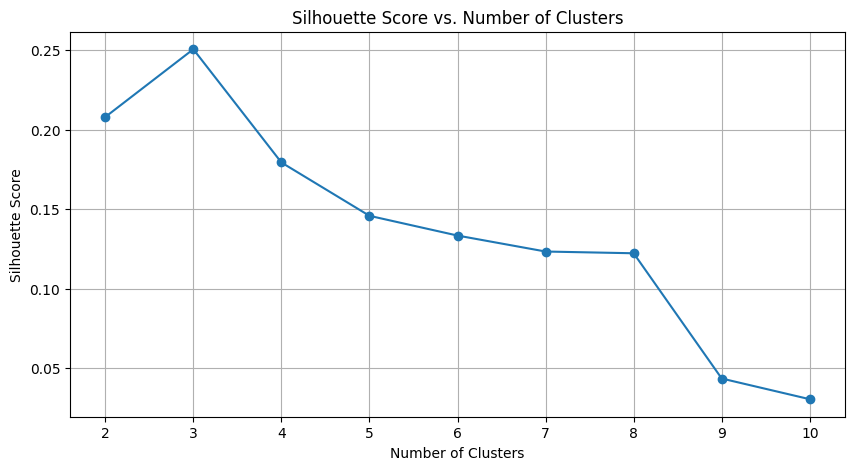

The optimal number of clusters with GMM is 3


In [23]:
# ChatGPT Prompt: Write code to calculate silhouette score for GMM clustering and then find optimal number of clusters using the constructed class
# Note: Entire GMM class was given as input

min_clusters = 2
max_clusters = 10
silhouette_scores = []

for n_clusters in range(min_clusters, max_clusters + 1):
    gmm = GMM()
    gmm.fit(X,n_clusters,3)
    cluster_labels = gmm.predict_membership()
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg}")

# Find the optimal number of clusters
optimal_clusters = np.argmax(silhouette_scores) + min_clusters

plt.figure(figsize=(10, 5))
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.xticks(range(min_clusters, max_clusters + 1))
plt.grid(True)
plt.show()

print(f"The optimal number of clusters with GMM is {optimal_clusters}")

## Observations 

1. The silhouette score measures how close each data point in one cluster is to the data points in the neighboring clusters. A higher silhouette score indicates that the clusters are well-separated.
2. For both the K means and GMM clustering silhouette score is maximised at 3 clusters and we know from the data documentation that it has been made from 3 different clusters. Hence this is optimal